In [11]:
import argparse
import torch
import torchvision
from torchvision.transforms import transforms
import matplotlib.pyplot as plt
import numpy as np
import Net
import Unnormalize
from PIL import Image

accuracies = []
examples = []
epsilons = [0, .05, .1, .15, 1]
batch_size = 4

classes = {
        0 : 'plane',
        1 : 'car',
        2 :'bird',
        3 : 'cat',
        4 : 'deer',
        5 : 'dog',
        6 : 'frog',
        7 : 'horse',
        8 : 'ship',
        9 : 'truck'
    }

transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # normalize the pics (bad for displaying w matplot)
    ]
)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
if device != "cpu":
    print(f"Using CUDA device {device}")

Using CUDA device cpu


In [3]:

trainset = torchvision.datasets.CIFAR10(
    root='../data',
    train=True,
    download=True,
    transform=transform
    )

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

testset = torchvision.datasets.CIFAR10(
    root='../data',
    train=False,
    download=True,
    transform=transform
)

testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [7]:
# Instantiate the network
net = Net.Net(True, device)
net.to(device)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
# Train the network
net.train(4, trainloader)
net.save("../net/net_notebook")

In [8]:
# Load a separate network instead of training a new one
net.load_state_dict(torch.load("../nets/net.pth", map_location=device))

<All keys matched successfully>

In [9]:
# Test the network's accuracy
net.test(testloader)

Accuracy of the network on the 10k test images: 54%


In [12]:
# Load image from path and resize to 32x32
img = Image.open("../img/truck.jpg").convert('RGB')
img = img.resize((32, 32))

# Define transform to tensor and noramlize
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Convert image to tensor
img = transform(img)
prediction = net.test_image(img)
print( f"Prediction: {classes[prediction]}" )

Prediction: truck


In [13]:
# Generate adversarial examples
for eps in epsilons:
    acc, ex = net.test_perturbed(testloader, eps)
    accuracies.append(acc)
    # Each index in examples is a tuple of (initial_prediction, final_prediction, image)
    examples.append(ex)

Accuracy of the network with Epsilon 0 on the perturbed images: 54%
Accuracy of the network with Epsilon 0.05 on the perturbed images: 10%
Accuracy of the network with Epsilon 0.1 on the perturbed images: 3%
Accuracy of the network with Epsilon 0.15 on the perturbed images: 1%
Accuracy of the network with Epsilon 1 on the perturbed images: 3%


5
[0.54, 0.1, 0.03, 0.01, 0.03]
5
[0, 0.05, 0.1, 0.15, 1]


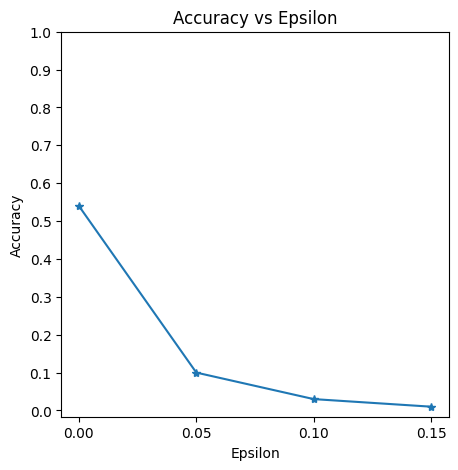

In [31]:
# Show the epilson vs accuracy graph
for i in range(len(accuracies)):
    accuracies[i] = accuracies[i] / 100
    
plt.figure(figsize=(5,5))
# Last epsilon is 1, we don't want to plot it
plt.plot(epsilons[:-1], accuracies[:-1], "*-")
# Last epsilon is 1, we don't want to plot it, so we use epsilons[-2] + epsilons[1]
plt.xticks(np.arange(epsilons[0], epsilons[-2] + epsilons[1], step=float(epsilons[1])))
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()


In [ ]:
# Need to unnormalize the images (normalized images = bad for displaying w matplot)
un = Unnormalize.Unnormalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

# Plot all images in examples
# TODO : plot 4 examples per epsilon
x = 0
plt.figure(figsize=(8,10))
for i in range(len(examples)):
    for j in range(len(examples[i])):
        x += 1
        plt.subplot(len(epsilons),len(examples[0]), x)
        init_pred, final_pred, img_list = examples[i][j]
        for img in img_list:
            img = un(torch.from_numpy(img))
            # Convert to numpy and transpose to (32, 32, 3)
            img = img.permute(*torch.arange(img.dim() - 1, -1, -1))
            plt.imshow(img)
            plt.title(f"Image with epsilon {epsilons[i]}")
plt.tight_layout()
plt.show()